# Circle GAN with MINE

## Import libraries

In [342]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

## Set random seed

In [343]:
def set_rand_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_rand_seed(377)

## Generate 2_D circle data

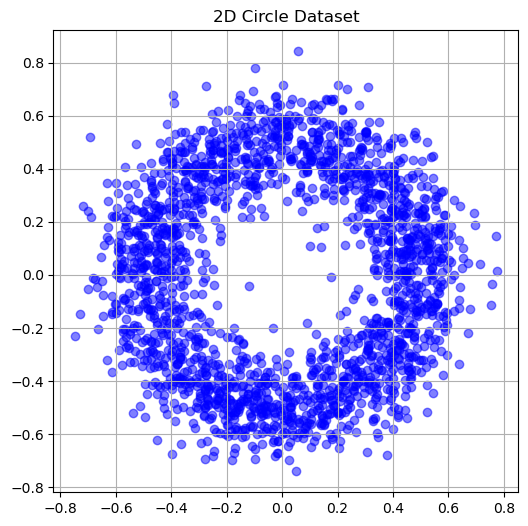

In [344]:
def generate_circle_data(num_samples, radius, noise=0.05):
    angles = np.random.uniform(0, 2 * np.pi, num_samples)
    x = radius * np.cos(angles) + np.random.normal(0, noise, num_samples)
    y = radius * np.sin(angles) + np.random.normal(0, noise, num_samples)
    return np.vstack((x, y)).T

circle_data = generate_circle_data(2000, radius=0.5, noise=0.1)
plt.figure(figsize=(6, 6))
plt.scatter(circle_data[:, 0], circle_data[:, 1], alpha=0.5, c='blue')
plt.title("2D Circle Dataset")
plt.grid(True)
plt.show()

## Generator

In [345]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(10, 128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 2),
            nn.Tanh()
        )

    def forward(self, x):
        return self.network(x)

## Discriminator

In [346]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.network(x)

## MINE

In [347]:
class MINE(nn.Module):
    def __init__(self, input_dim):
        super(MINE, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x, y):
        """
        Forward pass through the MINE network.

        Args:
            x (torch.Tensor): The first set of variables (e.g., latent variables).
            y (torch.Tensor): The second set of variables (e.g., data representations).

        Returns:
            torch.Tensor: The estimated joint or marginal scores.
        """
        inputs = torch.cat((x, y), dim=1)  # Concatenate inputs along the feature dimension
        return self.network(inputs)

## Training GAN with MINE

In [348]:
n_epochs = 20
lr = 1e-3
batch_size = 64
num_samples = 5000

adversarial_loss = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator()
mine = MINE(input_dim=11)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_MINE = torch.optim.Adam(mine.parameters(), lr=lr, betas=(0.5, 0.9))

Tensor = torch.FloatTensor

# Convert circle_data to PyTorch Tensor and create DataLoader
circle_tensor = torch.tensor(circle_data, dtype=torch.float32)
circle_labels = torch.ones(circle_data.shape[0], 1)
dataset = TensorDataset(circle_tensor, circle_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [349]:
def plot_generated_samples(generator, epoch, num_samples=num_samples, latent_dim=10):
    """
    Plot samples generated by the generator model.

    Args:
        generator: The generator model to generate samples.
        epoch: The current epoch number, used for title or saving purposes.
        num_samples: The number of samples to generate.
        latent_dim: The dimensionality of the random noise input to the generator.
    """
    # Generate random noise
    z = torch.randn(num_samples, latent_dim)
    z = z.to(next(generator.parameters()).device)
    # Generate data using the generator
    generated_samples = generator(z).detach().cpu().numpy()

    # Plot the distribution of generated data
    plt.figure(figsize=(6, 6))
    plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, c='red', label="Generated Samples")
    plt.title(f"Generated Samples at Epoch {epoch+1}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [350]:
def train_mine_gan(MI_weight):
    """
    Args:
        MI_weight (float): The weight applied to the mutual information term in the
                           generator's loss function. This controls the trade-off
                           between adversarial loss and mutual information maximization.
    """
    # Lists to store loss values and MI for plotting
    g_loss_history = []
    d_loss_history = []
    mi_history = []

    for epoch in range(n_epochs):
        for i, (x, _) in enumerate(dataloader):
            valid = Variable(Tensor(x.size(0), 1).fill_(1.0), requires_grad=False)  # Real labels
            fake = Variable(Tensor(x.size(0), 1).fill_(0.0), requires_grad=False)  # Fake labels
            z = Variable(Tensor(np.random.normal(0, 1, (x.shape[0], 10))))  # Latent dim = 10
            x_tilde = generator(z)

            # derive MI and train MINE
            optimizer_MINE.zero_grad()
            real_rep = discriminator(x)  # Representation for real samples
            fake_rep = discriminator(x_tilde.detach())  # Representation for generated samples
            joint_score = mine(z, real_rep)  # Joint distribution score
            marginal_score = mine(z, fake_rep)  # Marginal distribution score
            mine_loss = -(torch.mean(joint_score) - torch.log(torch.mean(torch.exp(marginal_score))))
            MI_estimated = -mine_loss.detach()
            mine_loss.backward()
            optimizer_MINE.step()

            # train generator
            optimizer_G.zero_grad()
            g_loss = adversarial_loss(discriminator(x_tilde), valid) - MI_weight * MI_estimated  # Weight mutual info by 0.1
            g_loss.backward()
            optimizer_G.step()

            # train discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(x), valid)
            fake_loss = adversarial_loss(discriminator(x_tilde.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

        # Log losses and MI for this epoch
        g_loss_history.append(g_loss.item())
        d_loss_history.append(d_loss.item())
        mi_history.append(MI_estimated.item())

        if epoch % 2 == 1:
            print(
                "[Epoch %d/%d] [D loss: %f] [G loss: %f] [MI (-mine_loss): %f]"
                % (epoch+1, n_epochs, d_loss.item(), g_loss.item(), MI_estimated.item())
            )
            plot_generated_samples(generator, epoch)

    # Plot the recorded losses and MI over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_epochs + 1), g_loss_history, label="Generator Loss (G)")
    plt.plot(range(1, n_epochs + 1), d_loss_history, label="Discriminator Loss (D)")
    plt.plot(range(1, n_epochs + 1), mi_history, label="Mutual Information (MI)", linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss / MI")
    plt.title("Loss and Mutual Information over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

## Only GAN (w = 0.0)

[Epoch 2/20] [D loss: 0.694607] [G loss: 0.813564] [MI (-mine_loss): 0.028013]


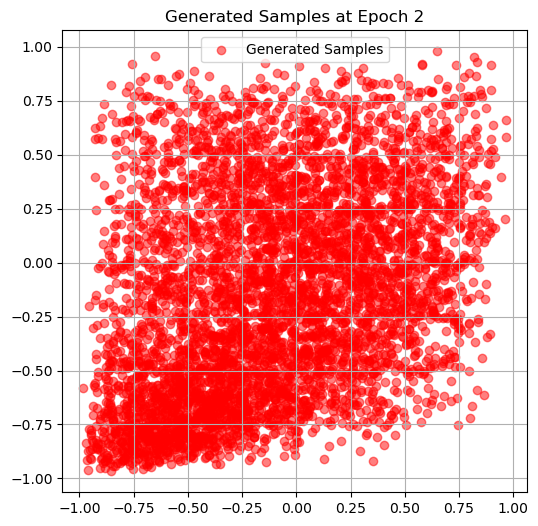

[Epoch 4/20] [D loss: 0.699759] [G loss: 0.768684] [MI (-mine_loss): -0.003212]


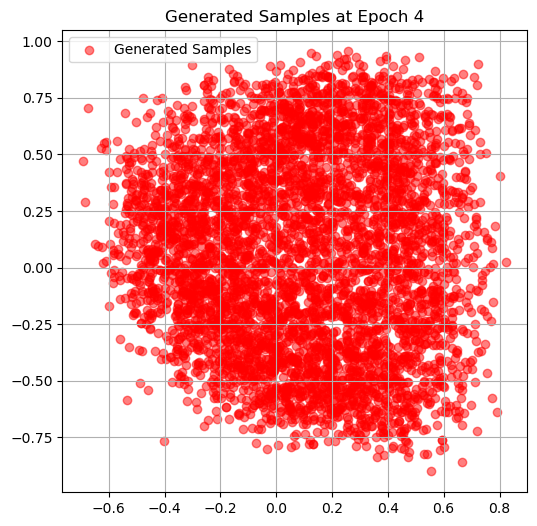

[Epoch 6/20] [D loss: 0.697861] [G loss: 0.743728] [MI (-mine_loss): -0.009157]


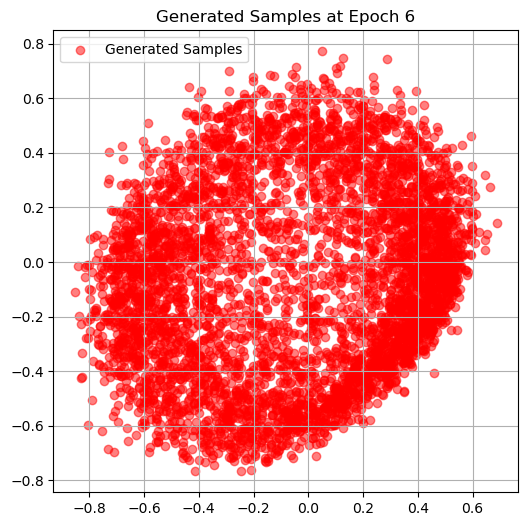

[Epoch 8/20] [D loss: 0.705694] [G loss: 0.651395] [MI (-mine_loss): -0.007044]


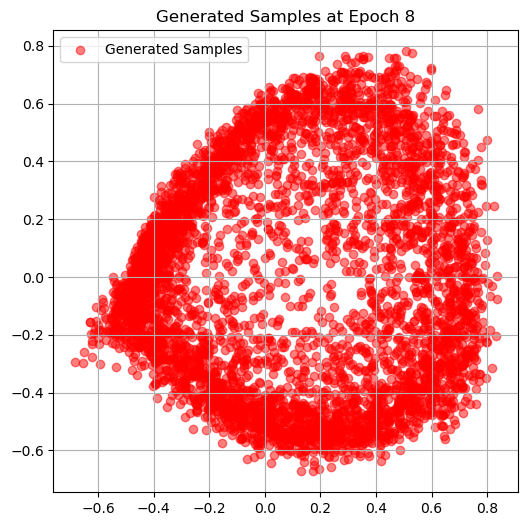

[Epoch 10/20] [D loss: 0.679067] [G loss: 0.756863] [MI (-mine_loss): 0.059043]


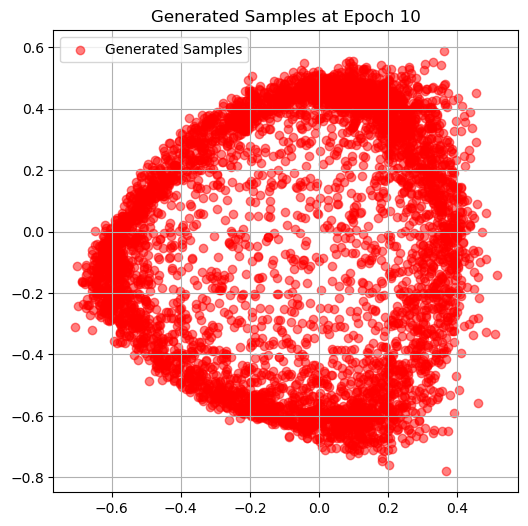

[Epoch 12/20] [D loss: 0.701129] [G loss: 0.707631] [MI (-mine_loss): -0.021384]


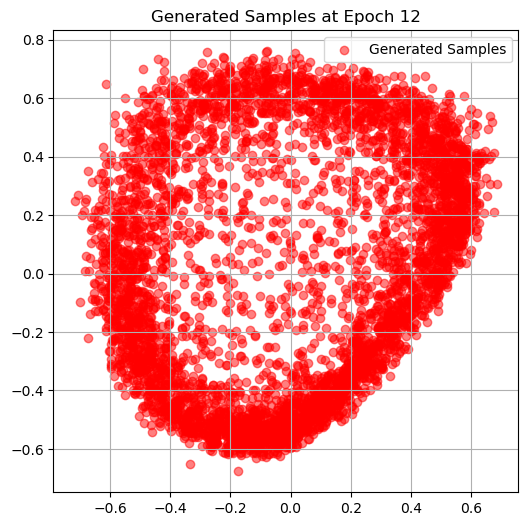

[Epoch 14/20] [D loss: 0.701948] [G loss: 0.674429] [MI (-mine_loss): -0.020543]


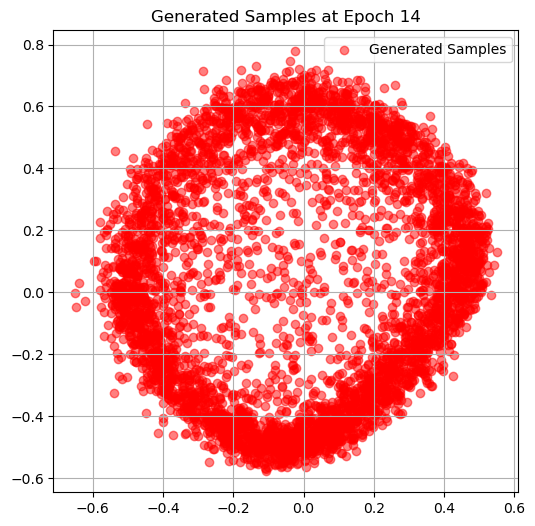

[Epoch 16/20] [D loss: 0.713683] [G loss: 0.705311] [MI (-mine_loss): -0.035185]


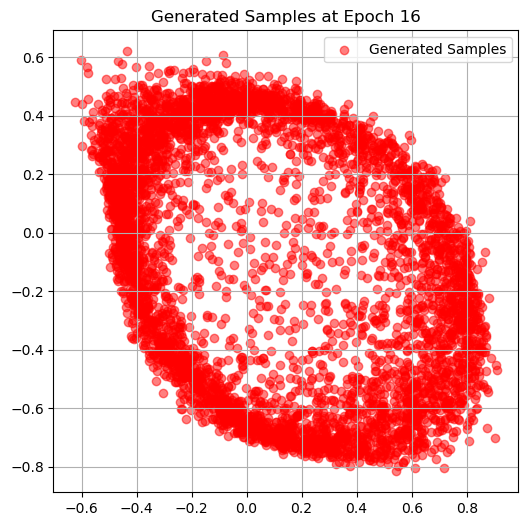

[Epoch 18/20] [D loss: 0.709317] [G loss: 0.690852] [MI (-mine_loss): 0.000920]


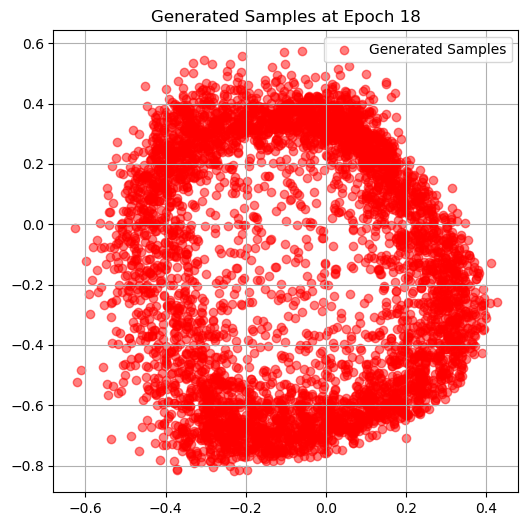

[Epoch 20/20] [D loss: 0.689743] [G loss: 0.709818] [MI (-mine_loss): 0.008547]


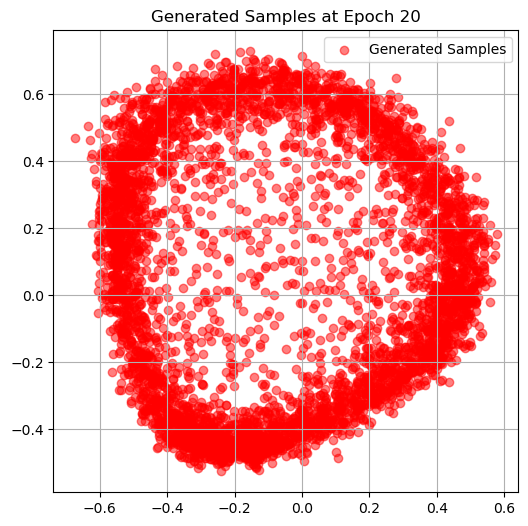

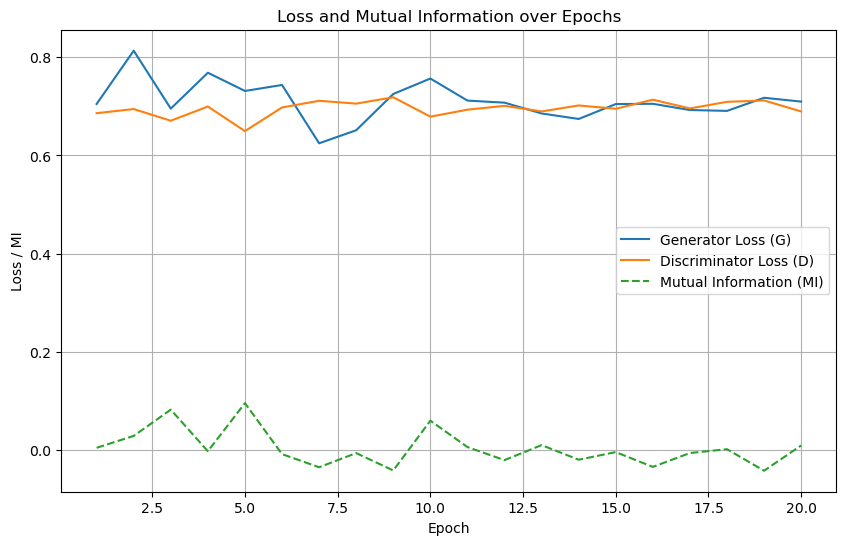

In [351]:
train_mine_gan(MI_weight=0.0)

## w = 1.0

[Epoch 2/20] [D loss: 0.707169] [G loss: 0.703877] [MI (-mine_loss): -0.020829]


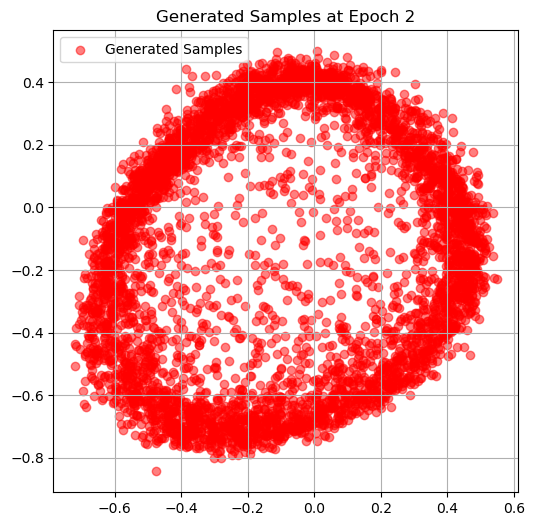

[Epoch 4/20] [D loss: 0.693241] [G loss: 0.688878] [MI (-mine_loss): 0.005555]


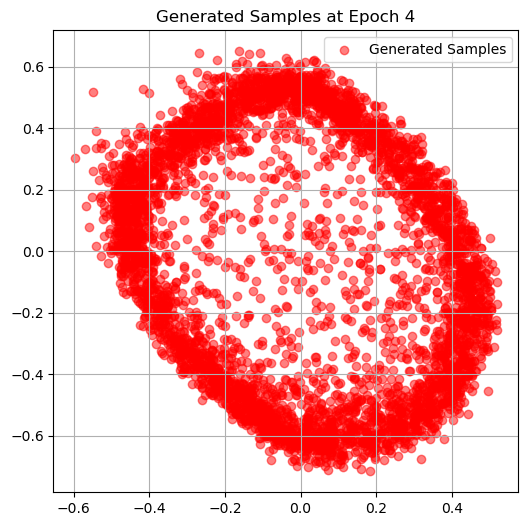

[Epoch 6/20] [D loss: 0.689775] [G loss: 0.700909] [MI (-mine_loss): 0.003426]


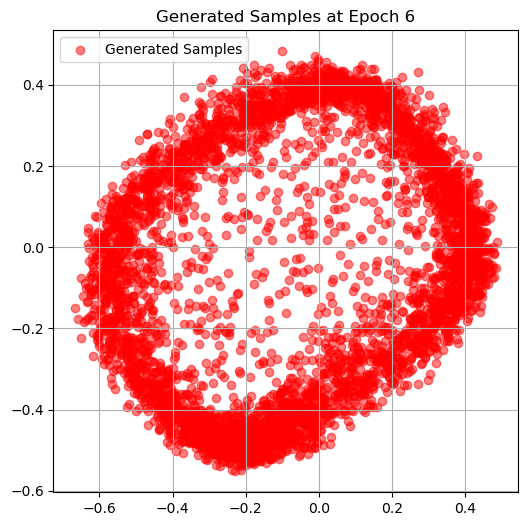

[Epoch 8/20] [D loss: 0.682134] [G loss: 0.652722] [MI (-mine_loss): 0.030264]


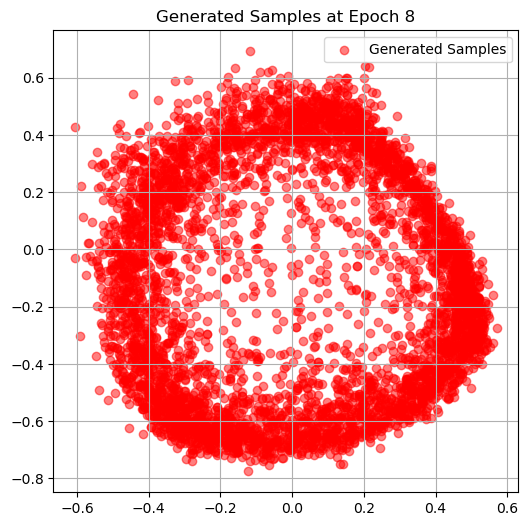

[Epoch 10/20] [D loss: 0.694416] [G loss: 0.710930] [MI (-mine_loss): 0.003248]


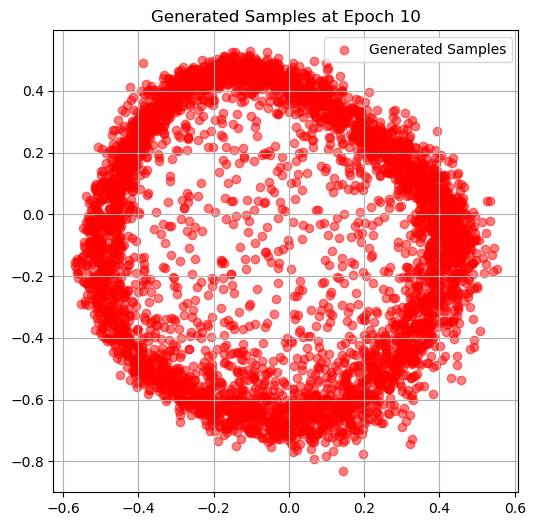

[Epoch 12/20] [D loss: 0.664416] [G loss: 0.707858] [MI (-mine_loss): 0.037305]


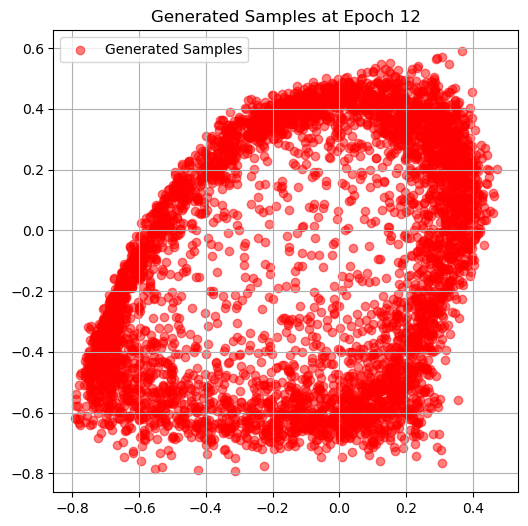

[Epoch 14/20] [D loss: 0.691010] [G loss: 0.699644] [MI (-mine_loss): 0.005199]


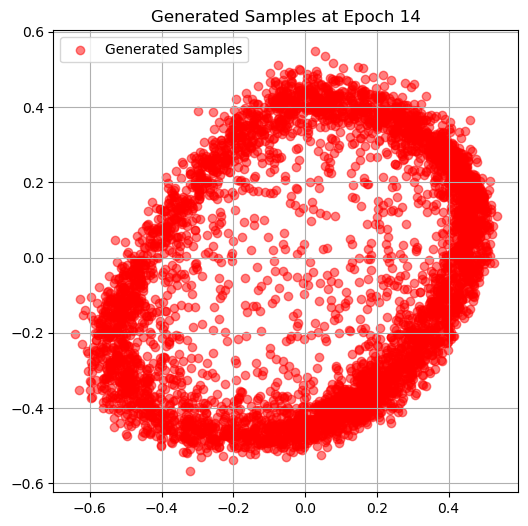

[Epoch 16/20] [D loss: 0.690240] [G loss: 0.713025] [MI (-mine_loss): 0.001452]


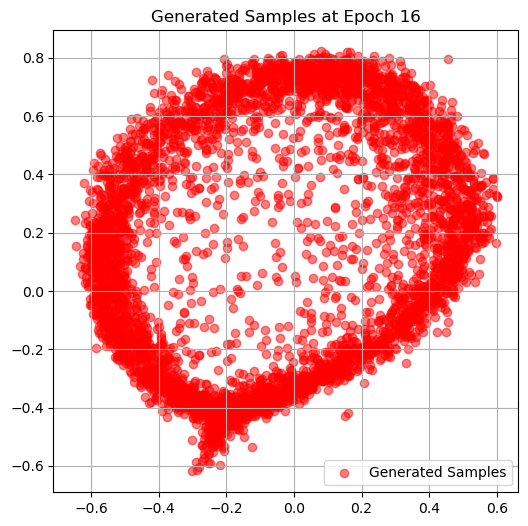

[Epoch 18/20] [D loss: 0.698139] [G loss: 0.658149] [MI (-mine_loss): 0.005318]


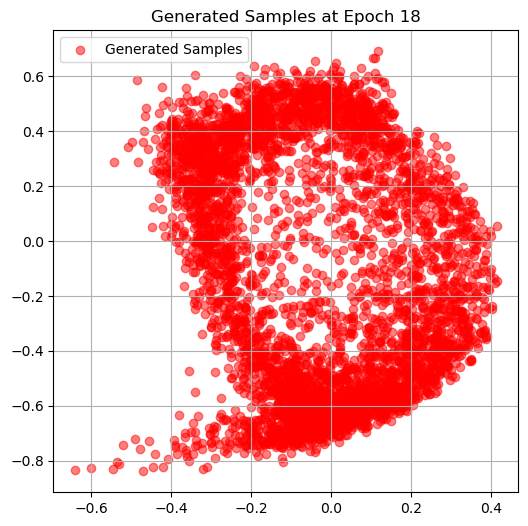

[Epoch 20/20] [D loss: 0.677399] [G loss: 0.670439] [MI (-mine_loss): 0.033142]


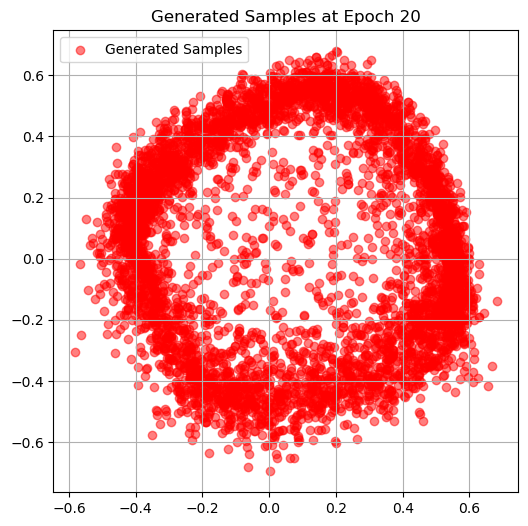

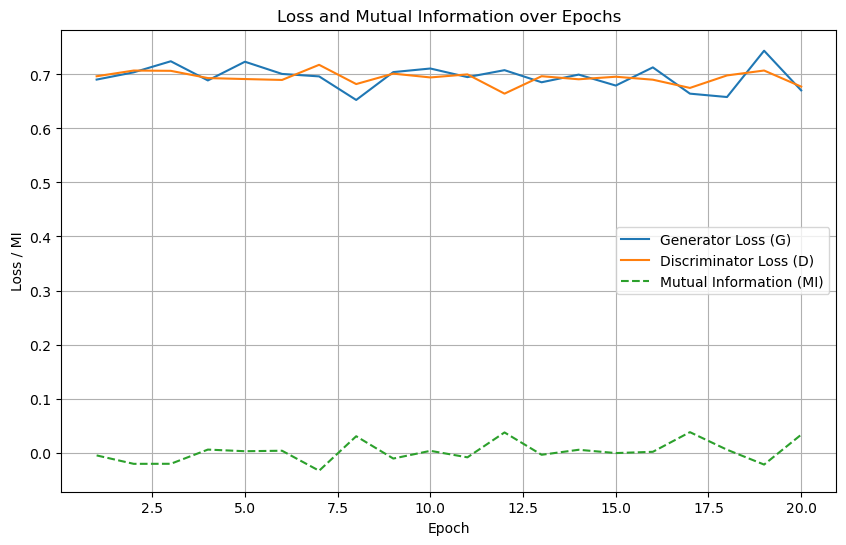

In [352]:
train_mine_gan(MI_weight=1.0)

## w = 0.1

[Epoch 2/20] [D loss: 0.691452] [G loss: 0.690936] [MI (-mine_loss): 0.003788]


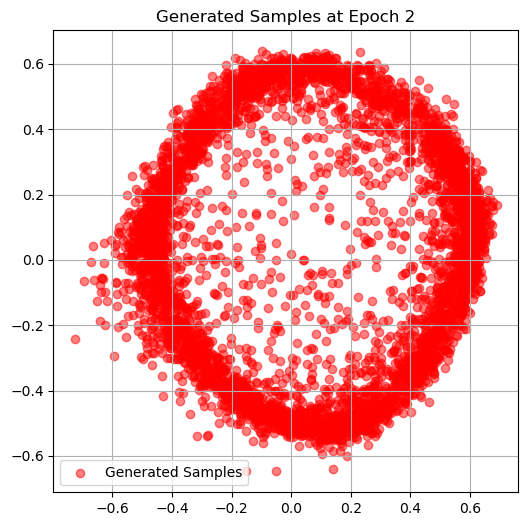

[Epoch 4/20] [D loss: 0.693711] [G loss: 0.663244] [MI (-mine_loss): 0.037611]


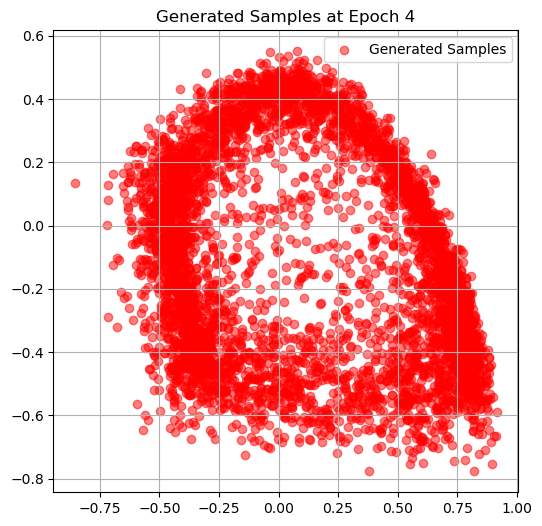

[Epoch 6/20] [D loss: 0.700128] [G loss: 0.691648] [MI (-mine_loss): -0.006230]


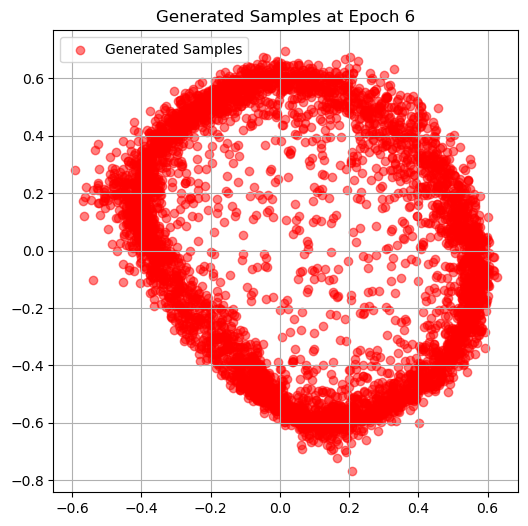

[Epoch 8/20] [D loss: 0.693707] [G loss: 0.678368] [MI (-mine_loss): 0.000090]


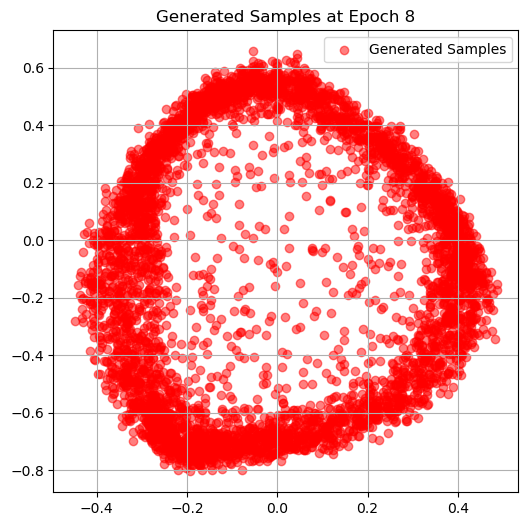

[Epoch 10/20] [D loss: 0.694658] [G loss: 0.689433] [MI (-mine_loss): -0.000654]


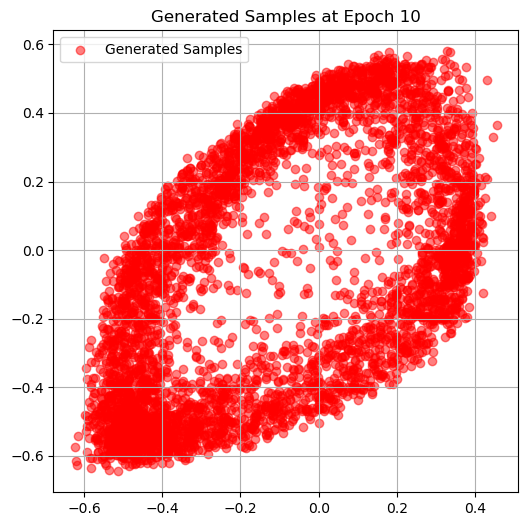

[Epoch 12/20] [D loss: 0.691333] [G loss: 0.671811] [MI (-mine_loss): 0.003633]


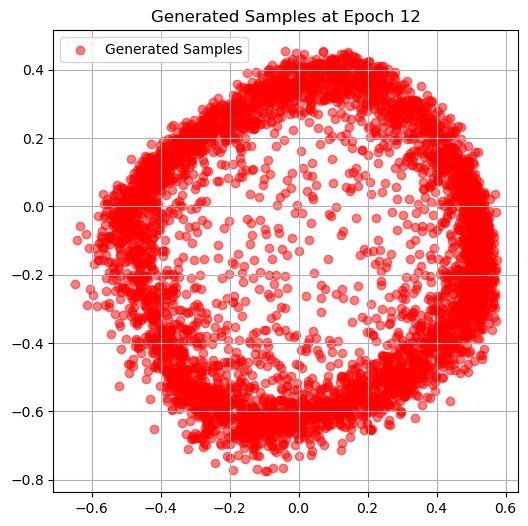

[Epoch 14/20] [D loss: 0.696198] [G loss: 0.708891] [MI (-mine_loss): -0.004306]


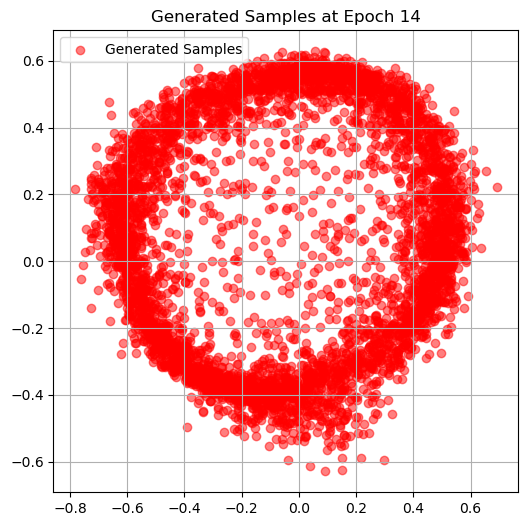

[Epoch 16/20] [D loss: 0.698303] [G loss: 0.714724] [MI (-mine_loss): -0.003913]


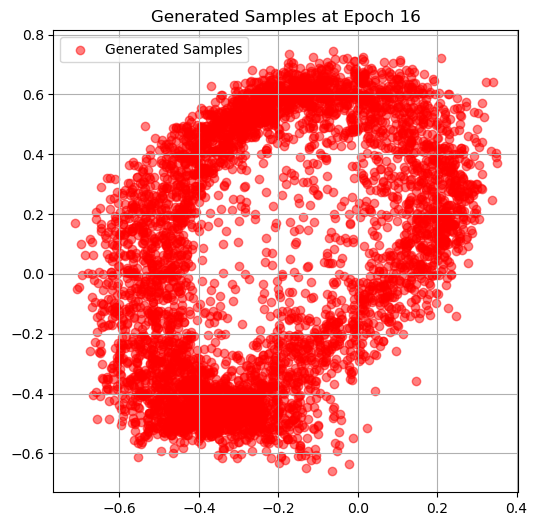

[Epoch 18/20] [D loss: 0.692663] [G loss: 0.696464] [MI (-mine_loss): -0.000033]


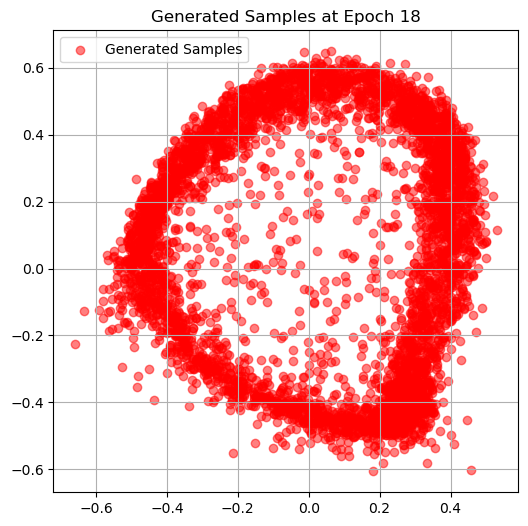

[Epoch 20/20] [D loss: 0.754285] [G loss: 0.666935] [MI (-mine_loss): -0.058881]


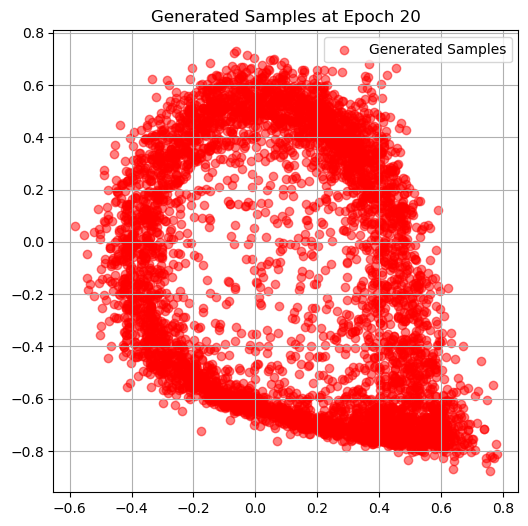

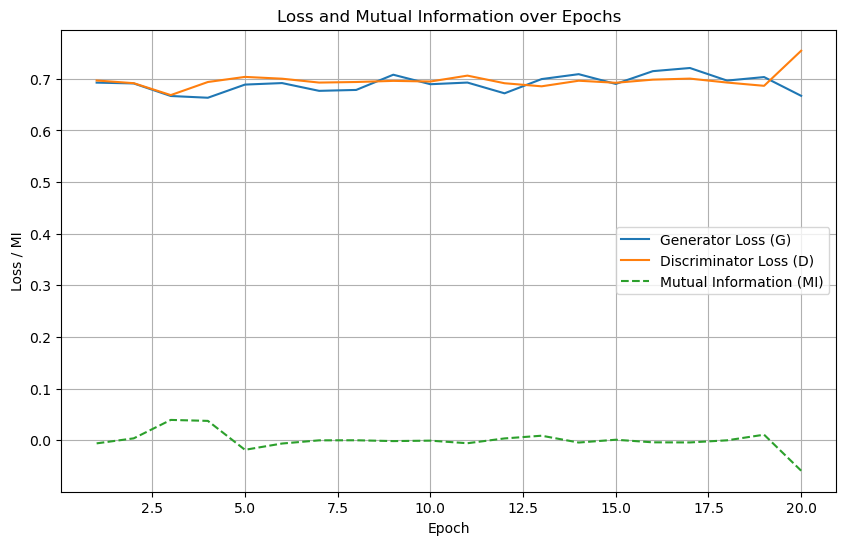

In [353]:
train_mine_gan(MI_weight=0.1)

## w = 0.01

[Epoch 2/20] [D loss: 0.699725] [G loss: 0.698909] [MI (-mine_loss): -0.014207]


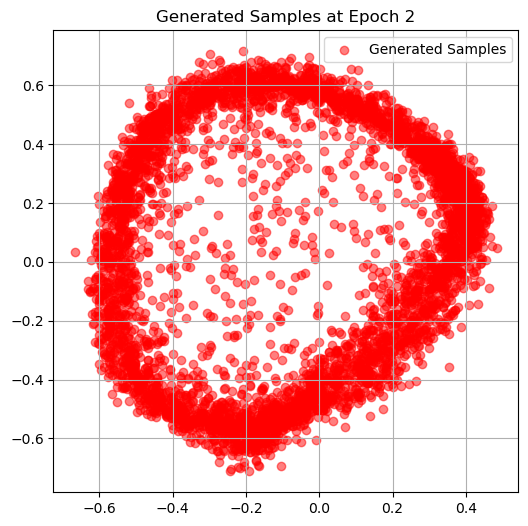

[Epoch 4/20] [D loss: 0.698449] [G loss: 0.691937] [MI (-mine_loss): -0.003654]


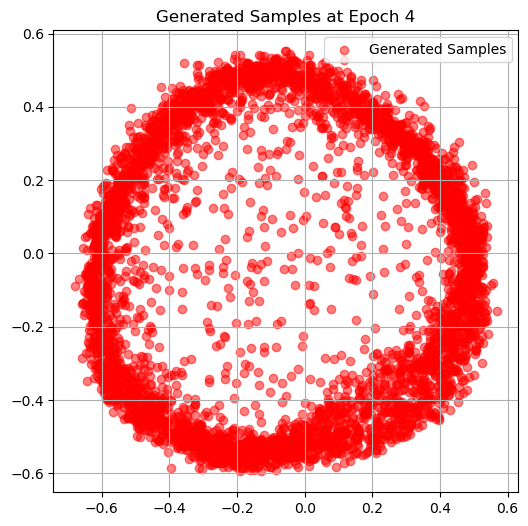

[Epoch 6/20] [D loss: 0.686643] [G loss: 0.690679] [MI (-mine_loss): 0.003549]


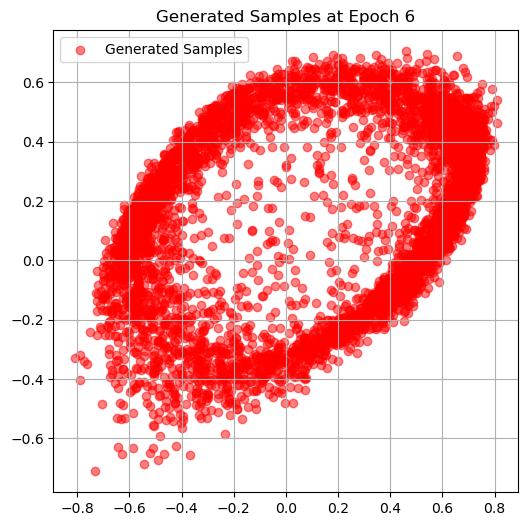

[Epoch 8/20] [D loss: 0.693024] [G loss: 0.675610] [MI (-mine_loss): 0.000737]


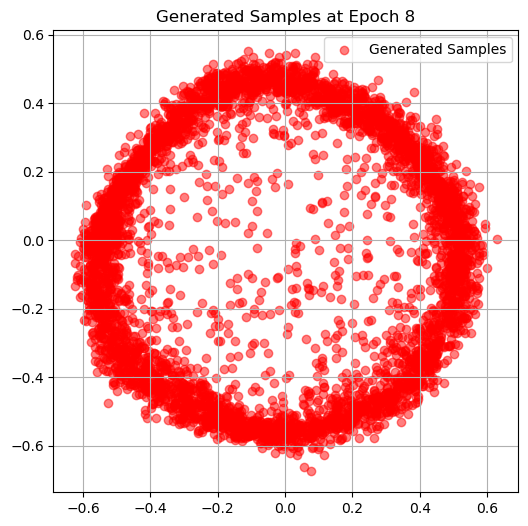

[Epoch 10/20] [D loss: 0.687495] [G loss: 0.681508] [MI (-mine_loss): 0.003178]


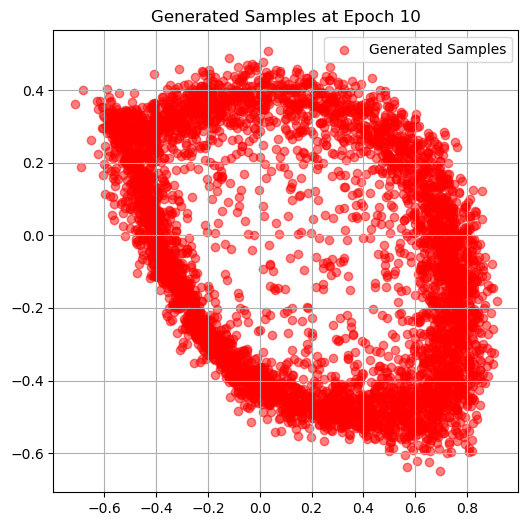

[Epoch 12/20] [D loss: 0.707521] [G loss: 0.705930] [MI (-mine_loss): -0.012092]


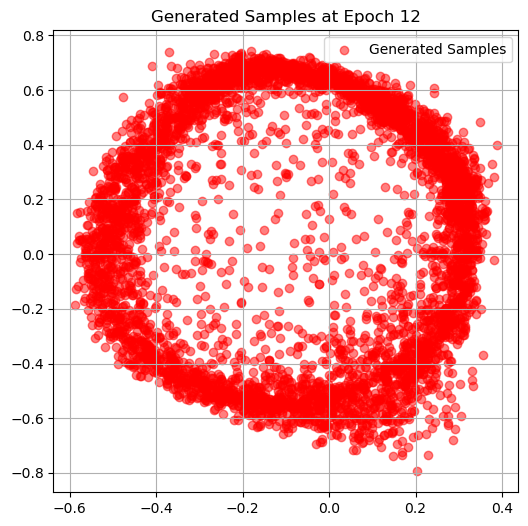

[Epoch 14/20] [D loss: 0.686370] [G loss: 0.712394] [MI (-mine_loss): 0.004239]


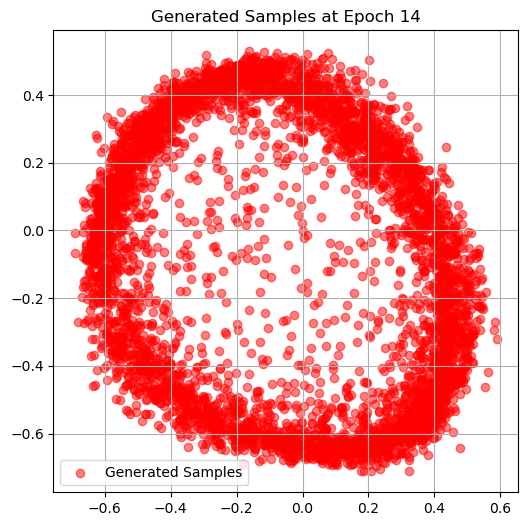

[Epoch 16/20] [D loss: 0.691318] [G loss: 0.675714] [MI (-mine_loss): 0.001880]


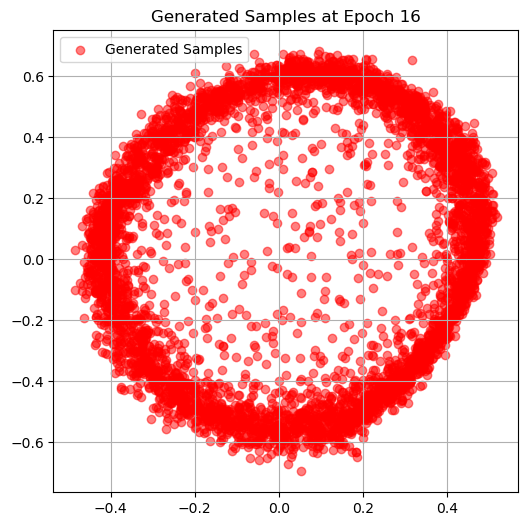

[Epoch 18/20] [D loss: 0.685292] [G loss: 0.691098] [MI (-mine_loss): 0.001648]


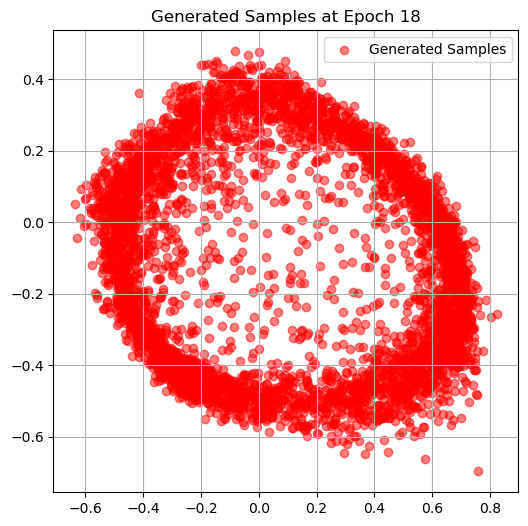

[Epoch 20/20] [D loss: 0.697864] [G loss: 0.675804] [MI (-mine_loss): -0.002318]


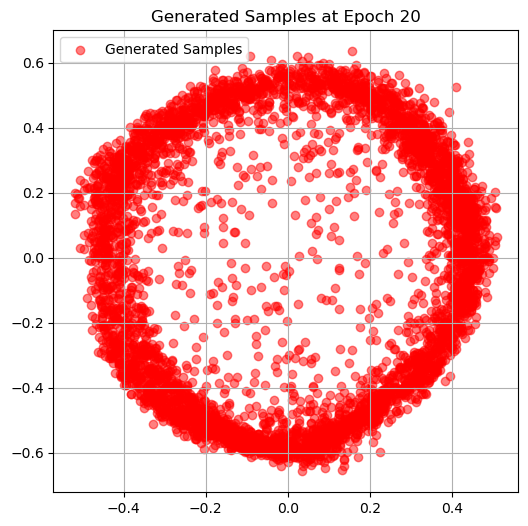

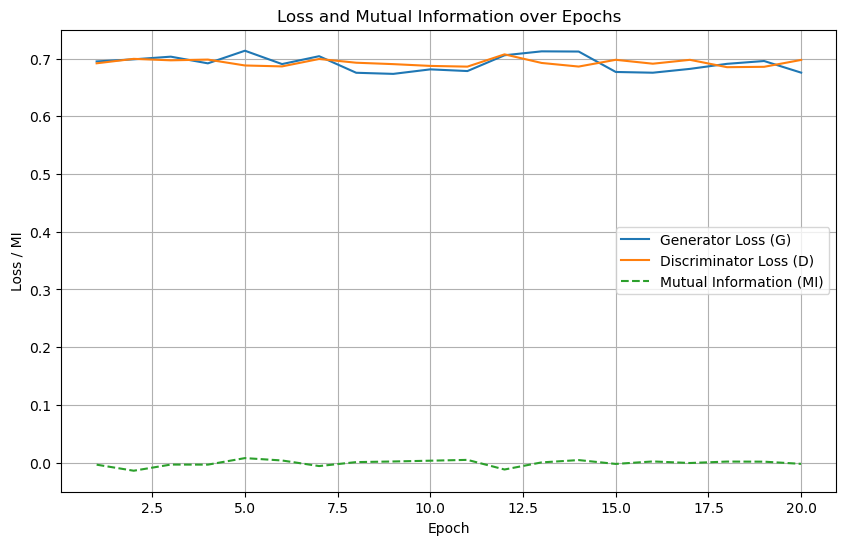

In [354]:
train_mine_gan(MI_weight=0.01)

## w = 0.001

[Epoch 2/20] [D loss: 0.697257] [G loss: 0.704896] [MI (-mine_loss): -0.000763]


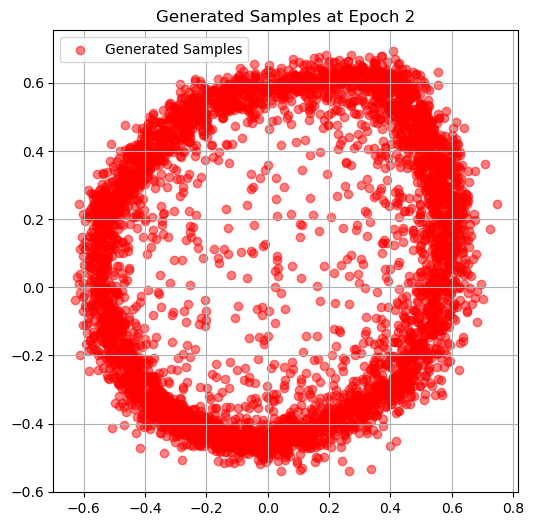

[Epoch 4/20] [D loss: 0.681174] [G loss: 0.695755] [MI (-mine_loss): 0.009541]


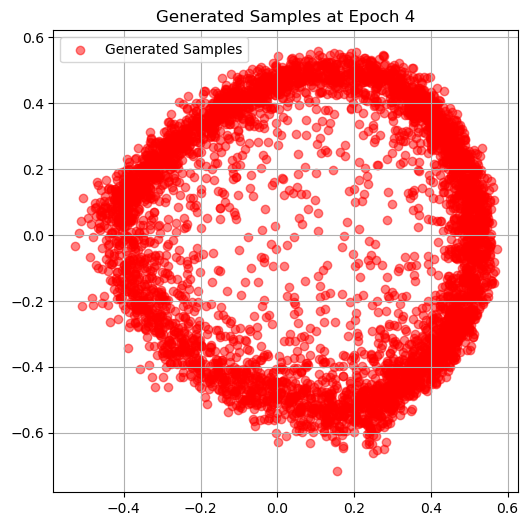

[Epoch 6/20] [D loss: 0.698045] [G loss: 0.685340] [MI (-mine_loss): -0.002123]


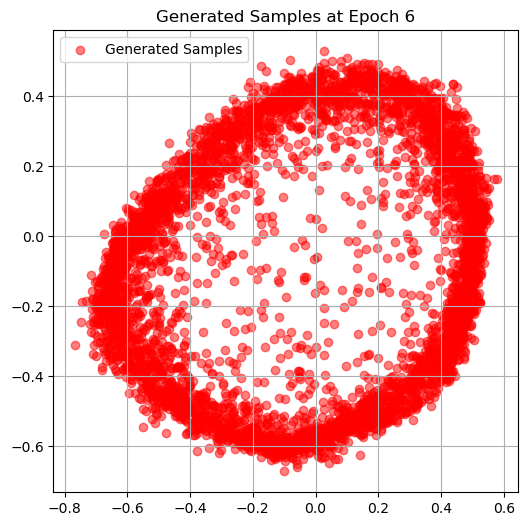

[Epoch 8/20] [D loss: 0.693614] [G loss: 0.675366] [MI (-mine_loss): -0.005714]


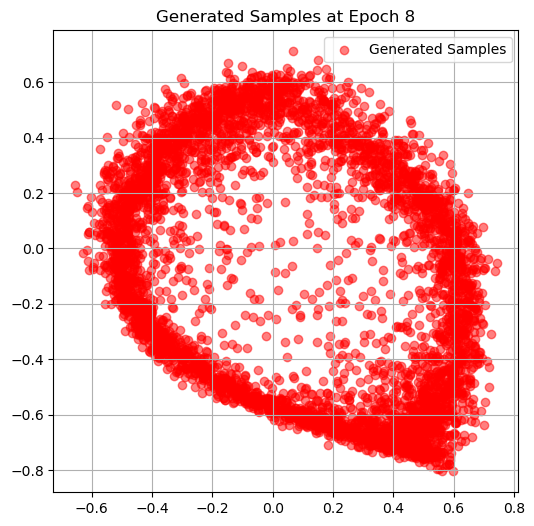

[Epoch 10/20] [D loss: 0.700584] [G loss: 0.713935] [MI (-mine_loss): -0.007663]


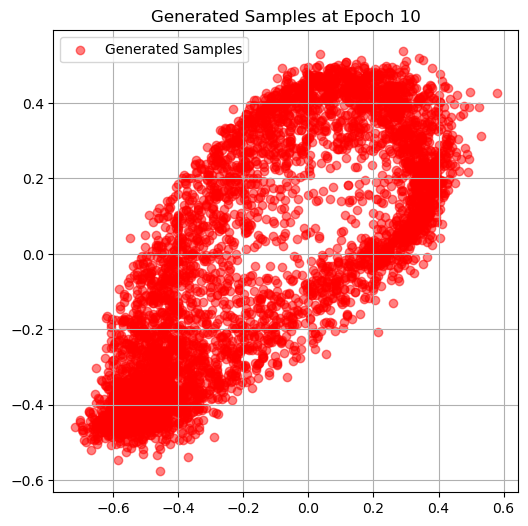

[Epoch 12/20] [D loss: 0.716857] [G loss: 0.702644] [MI (-mine_loss): -0.034875]


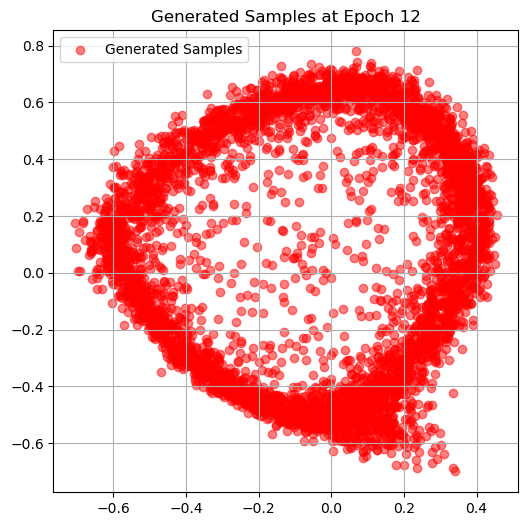

[Epoch 14/20] [D loss: 0.692556] [G loss: 0.696027] [MI (-mine_loss): 0.000161]


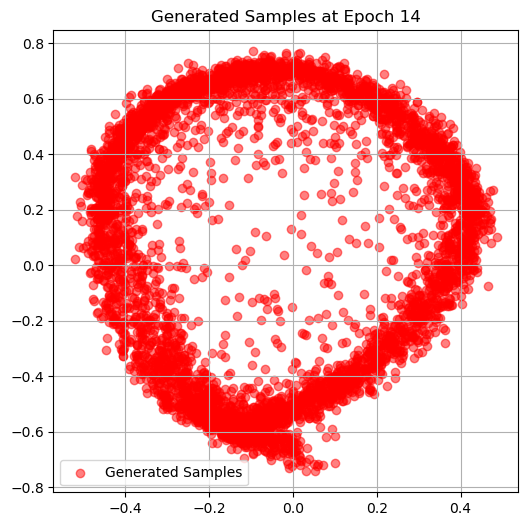

[Epoch 16/20] [D loss: 0.710748] [G loss: 0.681448] [MI (-mine_loss): -0.014527]


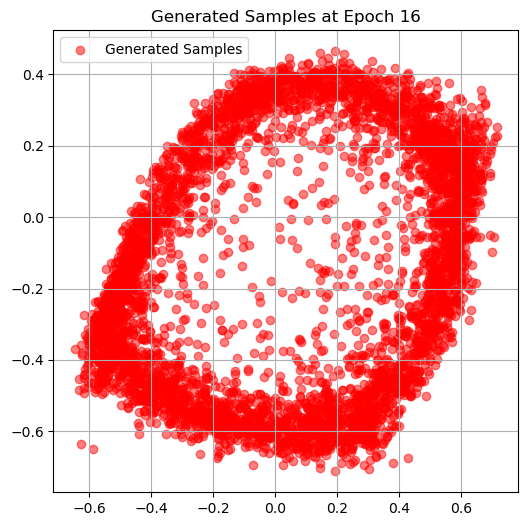

[Epoch 18/20] [D loss: 0.695272] [G loss: 0.664970] [MI (-mine_loss): 0.000547]


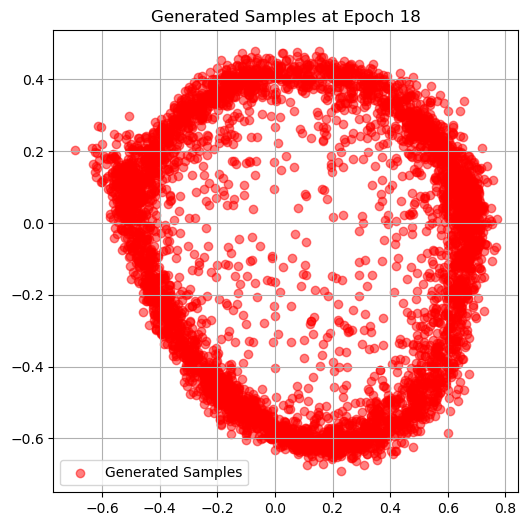

[Epoch 20/20] [D loss: 0.685607] [G loss: 0.710535] [MI (-mine_loss): 0.005793]


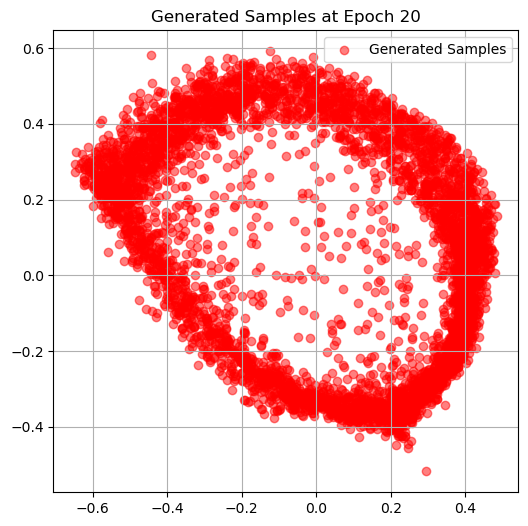

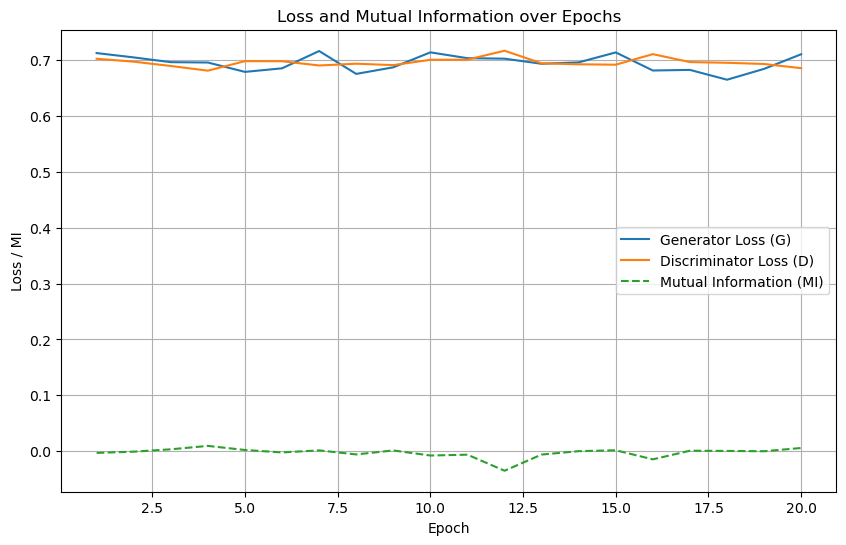

In [355]:
train_mine_gan(MI_weight=0.001)